In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# manually add several records to infer power based on metrics
# input data records:
# - rider weight
# - bike weight
# - air resistance (C_d)

In [3]:
df_sheets = pd.read_excel("zwift_bike_data.xlsx", sheet_name=None)

df = pd.concat([v for v in df_sheets.values()], ignore_index=True)
df = df.drop(df.columns[0], axis = 1)
df["grade"] = df["grade"].str.replace("%", "").astype(float)

df= df.dropna(how = "any", axis = 0)
df.shape

(3400, 7)

In [4]:
df.head(2)

,bike_wheel_weight,Air_resistance_(Cd),weight,height,power,grade,speed
0,6.781,0.8391,65,170,100,-12.0,94.81
1,6.781,0.8391,65,170,100,-11.0,90.71


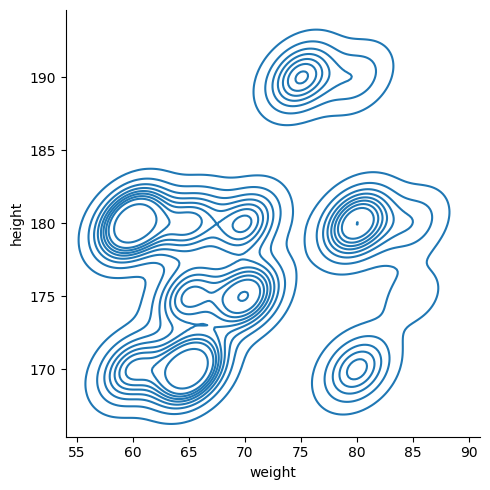

In [46]:
sns.displot(df, x="weight", y="height", kind="kde")

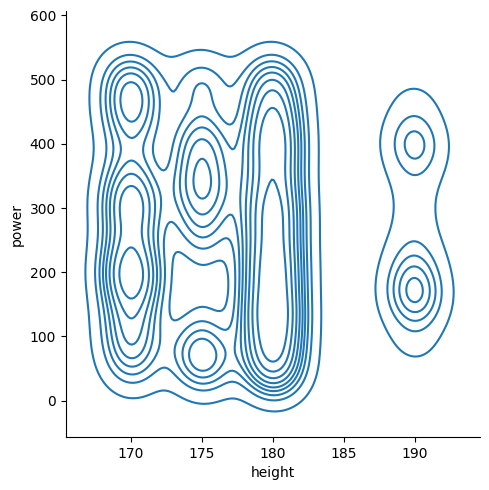

In [47]:
sns.displot(df, x="height", y="power", kind="kde")

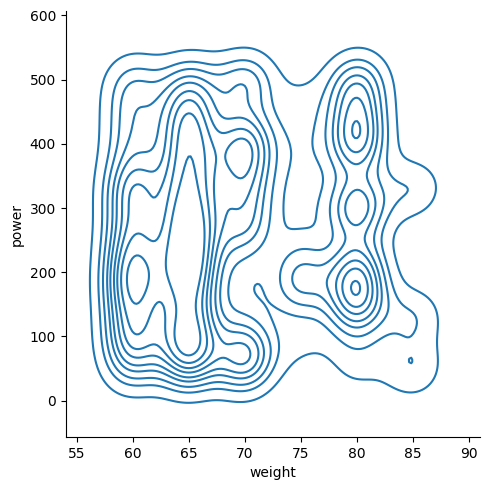

In [48]:
sns.displot(df, x="weight", y="power", kind="kde")

In [5]:
pd.crosstab(df["weight"], df["height"])

height,170,175,180,190
weight,,,,
60,250,0,500,0
65,500,250,250,0
70,0,350,250,0
75,0,0,0,250
80,200,0,350,100
85,0,50,100,0


In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [7]:
def cross_val_tree_pruning(X_train, y_train):
    d3 = DecisionTreeRegressor(random_state = 101, criterion = "absolute_error")
    d3.fit(X_train, y_train)
    print("Tree Train RMSE: {:.4f}\n".format((mean_squared_error(y_train, d3.predict(X_train)))))

    # Compute impurities to look for an adequate pruning term
    path = d3.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # Plot the impurity level given ccp_alpha
    # plt.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
    # plt.xlabel("effective alpha")
    # plt.ylabel("total impurity of leaves")
    # plt.title("Total Impurity vs effective alpha for training set")
    # plt.show()

    # Tree Pruning (we are overfitting - Accuracy: 100% in training)
    tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                                for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                        num = 5)]}

    tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 101, criterion = "absolute_error"),
                            tree_params, cv = 3, n_jobs = 6, verbose = 10,
                            return_train_score = True)
    tree_grid.fit(X_train, y_train)

    return tree_grid.best_estimator_

In [ ]:
df["bike_wheel_weight"]

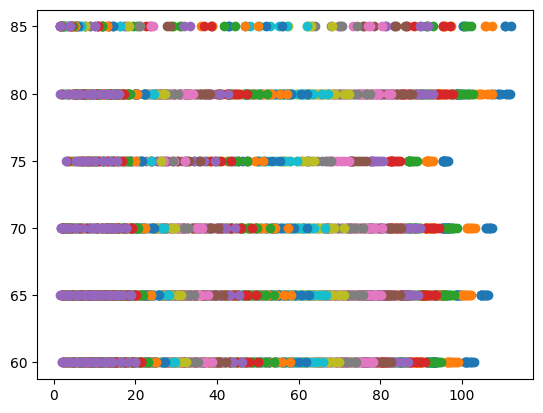

In [16]:
for g in df["grade"].unique():
    plt.scatter(df[df["grade"] == g]["speed"], df[df["grade"] == g]["weight"])

In [12]:
px.scatter_3d(df, x='speed', y='grade', z='power')

In [61]:
# def sigmoid_speed(grade, k):
#     vmax = 100
#     return 100 / (1 + np.exp(-k * grade))

# def power_function(X, C1, C2, C3, C4):
#     # X = [speed, weight, bk_weight, grade]
#     # Assuming air resistance, rolling resistance, and gravity contribute to power
#     air_resistance = C1 * X[0]**3  # Cubic dependence for air resistance
#     rolling_resistance = C2 * X[0]  # Linear dependence for rolling resistance
#     g = 9.81
#     gravity = C3 * ((X[1] + X[2]) * g * np.sin(np.radians(X[3])))  # Gravity force component
#     return air_resistance + rolling_resistance + gravity + C4




def power_function_1(X, c1, c2, c3, c4, c5, c6):
    # X = ["speed", "grade", "Air_resistance_(Cd)", "height", "weight", "bike_wheel_weight"]
    return c1*(X[0]**3) + c2*(X[1]**2) + (c3*X[2]) + (c4*X[3]) + (c5*(X[4] + X[5])) + c6

def power_function_2(X, c1, c2, c3, c4, c5, c6, c7):
    # X = ["speed", "grade", "Air_resistance_(Cd)", "height", "weight", "bike_wheel_weight"]
    return c1*((110 / (1 + np.exp(-c2 * X[1])))**3) + c3*(X[1]**2) + (c4*X[2]) + (c5*X[3]) + (c6*(X[4] + X[5])) + c7

def power_function_3(X, c1, c2, c3, c4, c5, c6, c7, c8, c9):
    # X = ["speed", "grade", "Air_resistance_(Cd)", "height", "weight", "bike_wheel_weight"]
    return c1*((110 / (2 + np.exp(-c3 * X[1] + c4)))**3) + c5*(X[1]**2) + (c6*X[2]) + (c7*X[3]) + c8*((X[4] + X[5])**2) + c9

def power_function_4(X, c1, c2, c3, c4, c5, c6):
    # X = ["speed", "grade", "Air_resistance_(Cd)", "height", "weight", "bike_wheel_weight"]
    return c1*(X[0]**3) + c2*(X[1]**3) + c3*(X[2]**2) + c4*(X[3]) + c5*((X[4] + X[5])**2) + c6


def best_interpolation(func_list, x_data):


    cols_subset = ["speed", "grade", "Air_resistance_(Cd)", "height", "weight", "bike_wheel_weight"]

    results = []
    for n, f in enumerate(func_list):

        # Perform the curve fitting
        params, _ = curve_fit(f, x_data[cols_subset].values.T, x_data["power"])

        predicted_power = x_data[cols_subset].apply(lambda row: f(row, *params), axis = 1)

        results.append([n, f, params,
                        (predicted_power - x_data["power"]).tolist(),
                        mean_squared_error(predicted_power, x_data["power"]),
                        mean_absolute_error(predicted_power, x_data["power"]),
                        100*(mean_absolute_percentage_error(predicted_power, x_data["power"]))
                        ])
    
    best_iter = min(results, key = lambda v: v[6])

    best_fun = best_iter[1]
    best_fun = best_iter[2]
    best_metrics = best_iter[4:]

    return results

In [62]:
r = best_interpolation([power_function_1, power_function_2, power_function_3, power_function_4], df)

pd.DataFrame(r).drop([1, 2, 3], axis = 1)

C:\Users\matti\AppData\Local\Temp\ipykernel_17196\3443536946.py:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\matti\AppData\Local\Temp\ipykernel_17196\3443536946.py:23: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\matti\AppData\Local\Temp\ipykernel_17196\3443536946.py:43: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\matti\AppData\Local\Temp\ipykernel_17196\3443536946.py:27: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

,0,4,5,6
0,0,18608.974456,117.003381,43.969503
1,1,18726.775773,117.440068,44.066412
2,2,18736.342921,117.522810,44.094255
3,3,18431.679834,116.321707,43.761298


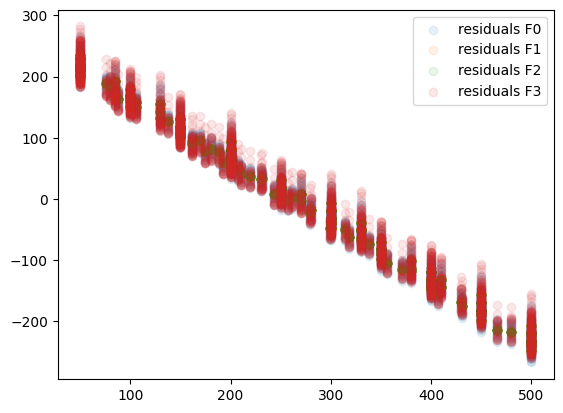

In [64]:
for n in range(len(r)):
    plt.scatter(df["power"], r[n][3], label = f"residuals F{n}", alpha = .1)
plt.legend();

In [30]:
power_func_dense = lambda s, w, bw, g, c1, c2, c3, c4: (c4 +\
                                                        (c1 * s**3) +\
                                                        (c2 * s) +\
                                                        (c3 * ((w + bw) * 9.81 * np.sin(np.radians(g))))
                                                        )

In [50]:
# drop additional columns since now they are constant
X = df.drop("power", axis = 1).drop(["bike_wheel_weight",
                                     "Air_resistance_(Cd)"
                                     ], axis = 1)
y = df["power"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)


tree_model = cross_val_tree_pruning(X_train, y_train)


lr = LinearRegression()
lr.fit(X_train, y_train)

# Perform the curve fitting
params, covariance = curve_fit(
    power_function,
    df[["speed", "weight", "bike_wheel_weight", "grade"]].values.T, df["power"]
)

predicted_power = df.apply(lambda row: power_func_dense(row["speed"],
                                                        row["weight"],
                                                        row["bike_wheel_weight"],
                                                        row["grade"],
                                                        *params),
                                                        axis = 1)

# --------------------------
print("*** Tree ***")
print("MSE: %.2f" % mean_squared_error(tree_model.predict(X_test), y_test))
print("MAE: %.2f" % mean_absolute_error(tree_model.predict(X_test), y_test))
print("MAPE: %.2f %s" % (100*(mean_absolute_percentage_error(tree_model.predict(X_test), y_test)), "%"))
print()
print("*** LR ***")
print("MSE: %.2f" % mean_squared_error(lr.predict(X_test), y_test))
print("MAE: %.2f" % mean_absolute_error(lr.predict(X_test), y_test))
print("MAPE: %.2f %s" % (100*(mean_absolute_percentage_error(lr.predict(X_test), y_test)), "%"))
print()
print("*** Interpolation ***")
print("MSE: %.2f" % mean_squared_error(predicted_power, df["power"]))
print("MAE: %.2f" % mean_absolute_error(predicted_power, df["power"]))
print("MAPE: %.2f %s" % (100*(mean_absolute_percentage_error(predicted_power, df["power"])), "%"))

Tree Train RMSE: 0.0000

Fitting 3 folds for each of 5 candidates, totalling 15 fits
*** Tree ***
MSE: 8738.78
MAE: 68.37
MAPE: 29.16 %

*** LR ***
MSE: 11911.06
MAE: 87.82
MAPE: 45.77 %

*** Interpolation ***
MSE: 10463.48
MAE: 81.28
MAPE: 41.26 %


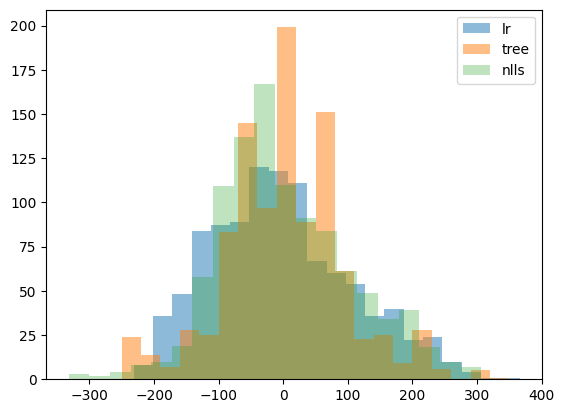

In [51]:
plt.hist(lr.predict(X_test) - y_test, label = "lr", alpha = .5, bins=20)
plt.hist(tree_model.predict(X_test) - y_test, label = "tree", alpha = .5, bins=20)
plt.hist((predicted_power - df["power"]).sample(len(y_test)), label = "nlls", alpha = .3, bins=20)
plt.legend()
plt.show()